In [1]:
################## IMPORT LIBRARIES ##################
import soundfile as sf
from IPython.display import Audio
import numpy as np
import random 
import pandas as pd
import os
import time
from os.path import join as pjoin
import tqdm
from acoustics.bands import third
import scipy.signal as sig
from IPython.display import Audio
# from masp import shoebox_room_sim as srs
from scipy.io import wavfile
#import mat73
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
import torch 
import sklearn 


In [2]:
################## IMPORT MY MODULES ##################

import sys
sys.path.append('../src')
import joa_helpers as hlp
import cond_waveunet_dataset as dset
import cond_waveunet_model as cwaveunet
import cond_waveunet_trainer
import cond_waveunet_eval as eval
import importlib
importlib.reload(hlp)
importlib.reload(dset)
importlib.reload(cwaveunet)
importlib.reload(eval)

def load_train_results(datapath, exp_tag, train_tag):
    args=torch.load(pjoin(datapath,exp_tag,train_tag,"trainargs.pt"))
    args.device="cpu"
    train_results=torch.load(pjoin(datapath,exp_tag,train_tag,"checkpointbest.pt"),map_location=args.device)
    return args,train_results

2024-04-16 10:25:04.708607: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 10:25:04.739538: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 10:25:06.535536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ubuntu/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ubuntu/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `li

### <font color='fuchsia'>Inspect datapoints:</font>

In [3]:
datapath="/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/"
exp_tag="runs-exp-14-04-2024"
train_tag="14-04-2024--23-47_many-to-many_stft_1"

args,train_results=load_train_results(datapath, exp_tag, train_tag)


In [4]:
################## LOAD DATASET AND CHECK 1 DATAPOINT SAMPLE  ##################

# instantiate a test data set 
args.split="test"
args.df_metadata="/home/ubuntu/joanna/reverb-match-cond-u-net/dataset-metadata/nonoise_48khz_guestxr.csv"
dataset=dset.DatasetReverbTransfer(args)
# get one data sample 
sContent, sStyle, sTarget, sAnecho, sEarly, sLate = dataset[10]

# playback for the data sample
audios=[sContent, sStyle, sTarget,sEarly, sLate, sEarly + sLate]
names=["sContent", "sStyle", "sTarget","sEarly", "sLate","sEarly + sLate" ]

for i,audio in enumerate(audios):
    print(names[i])
    audio=audio.squeeze(0).cpu()
    display(Audio(audio,rate=48e3))


sContent


sStyle


sTarget


sEarly


sLate


sEarly + sLate


In [5]:
2.048*48000

98304.0

###  <font color='fuchsia'>Inspect inference with trained models:</font>

In [6]:
################## LOAD MODELS AND TRAINING WEIGHTS  ##################


# load reverb encoder
model_ReverbEncoder=cwaveunet.ReverbEncoder(args)
model_ReverbEncoder

# check waveunet 
if bool(args.is_vae):
    model_waveunet=cwaveunet.varwaveunet(args)
else:
    model_waveunet=cwaveunet.waveunet(args)
model_waveunet

model_combined=cwaveunet.CombinedModel(model_waveunet,model_ReverbEncoder).to(args.device)
model_combined.eval()
# load training results
model_combined.load_state_dict(train_results["model_waveunet_state_dict"])


<All keys matched successfully>

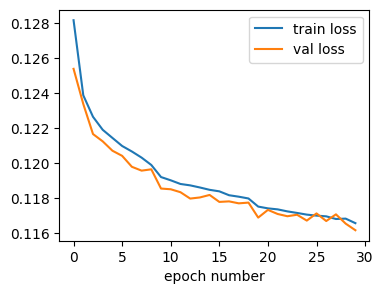

In [7]:
################## PLOT TRAINING LOSS EVOLUTION  ##################

# load and plot the loss evolution 
loss = list(zip(*train_results['loss']))
plt.figure()
plt.plot(loss[0],label="train loss")
plt.plot(loss[1],label="val loss")
plt.xlabel("epoch number")
plt.legend()
plt.show()

In [8]:
################## SEARCH FOR DATA POINTS FROM TEST SET WITH SPECIFIC PROPERTIES   ##################

# choose indices from a data set with specified difference
chosen_rt60_idx_list=dataset.get_idx_with_rt60diff(0.85,0.9)

/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../src/cond_waveunet_dataset.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_ds["diff_rt60"][0::2]=self.df_ds["diff_rt60"][1::2]


In [9]:
chosen_rt60_idx_list

[122,
 1071,
 1175,
 1574,
 2198,
 2621,
 2770,
 2788,
 3589,
 4223,
 4817,
 5126,
 5255,
 5399,
 7039]

In [10]:
################## INFERENCE FOR ONE DATA SAMPLE  ##################

def infer(model_combined, data, device):
    with torch.no_grad():
        # Function to infer target audio
        # ------------------------------

        # get datapoint
        sContent = data[0].to(device)
        sStyle=data[1].to(device)
        sTarget=data[2].to(device)
        # forward pass - get prediction of the ir
        start = time.time()
        sPrediction=model_combined(sContent.unsqueeze(0),sStyle.unsqueeze(0))
        if bool(args.is_vae):
            sPrediction=sPrediction[0]

        end = time.time()
        print("RTF="+str((end - start)/(sContent.shape[1]/48000)))
        
        return sContent, sStyle, sTarget, sPrediction
    

dp=chosen_rt60_idx_list[random.randint(0, len(chosen_rt60_idx_list) - 1)]
sContent, sStyle, sTarget, sPrediction =infer(model_combined, dataset[dp], args.device)

RTF=15.508768148720264


sContent:


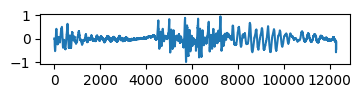

sStyle:


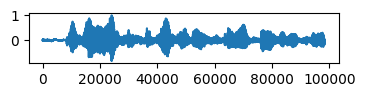

sTarget:


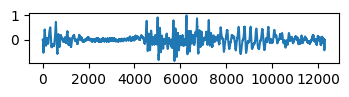

sPrediction:


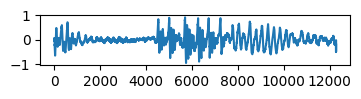

In [11]:
################## PLOT AND PLAY BACK CONTENT, STYLE, TARGET AND PREDICTION ##################

audios=[sContent, sStyle, sTarget, sPrediction]
names=["sContent", "sStyle", "sTarget", "sPrediction"]

plt.figure()
for i,audio in enumerate(audios):
    print(names[i]+":")
    plt.subplot(4,1,i+1)
    audio=audio.squeeze(0).cpu()
    if i==3:
        audio=audio.squeeze(0)
    # wavfile.write("sounds/dp_"+str(dp)+"_"+names[i]+".wav", int(48e3), audio.numpy())
    plt.plot(audio)
    plt.show()
    display(Audio(audio,rate=48e3))

In [41]:
def infer_shorttime(model_combined, data, device):
    with torch.no_grad():
        # Function to infer target audio
        # ------------------------------

        # get datapoint
        sContent = data[0].to(device)
        sStyle=data[1].to(device)
        sTarget=data[2].to(device)
        # forward pass - get prediction of the ir
        chunk_size=12288
        hanning_window = torch.tensor(np.hanning(chunk_size),dtype=torch.float32)
        chunks = [torch.mul(sContent[:,i:i+chunk_size],hanning_window) for i in range(0, sContent.shape[1], chunk_size)]
        sPrediction=torch.empty(1, 1, 0)
        for chunk in chunks:
            sPrediction_shorttime=model_combined(chunk.unsqueeze(0),sStyle.unsqueeze(0))
            sPrediction = torch.cat((sPrediction, sPrediction_shorttime),dim=2)
        
            print(sPrediction.shape)
            
        return sContent, sStyle, sTarget, sPrediction
    


args.content_sig_len=args.style_sig_len
dataset=dset.DatasetReverbTransfer(args)

sContent, sStyle, sTarget, sPrediction =infer_shorttime(model_combined, dataset[0], args.device)



torch.Size([1, 1, 12288])
torch.Size([1, 1, 24576])
torch.Size([1, 1, 36864])
torch.Size([1, 1, 49152])


torch.Size([1, 1, 61440])
torch.Size([1, 1, 73728])
torch.Size([1, 1, 86016])
torch.Size([1, 1, 98304])


In [33]:
sPrediction.shape

torch.Size([1, 1, 98304])

sContent:


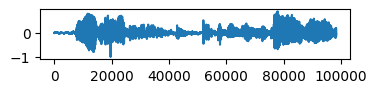

sStyle:


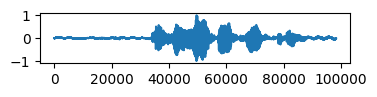

sTarget:


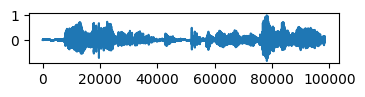

sPrediction:


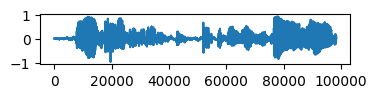

In [34]:
################## PLOT AND PLAY BACK CONTENT, STYLE, TARGET AND PREDICTION ##################

audios=[sContent, sStyle, sTarget, sPrediction]
names=["sContent", "sStyle", "sTarget", "sPrediction"]

plt.figure()
for i,audio in enumerate(audios):
    print(names[i]+":")
    plt.subplot(4,1,i+1)
    audio=audio.squeeze(0).cpu()
    if i==3:
        audio=audio.squeeze(0)
    # wavfile.write("sounds/dp_"+str(dp)+"_"+names[i]+".wav", int(48e3), audio.numpy())
    plt.plot(audio)
    plt.show()
    display(Audio(audio,rate=48e3))

In [45]:
################## INFERENCE FOR ONE DATA SAMPLE FROM THE WILD  ##################

def infer_wild(model_reverbenc, model_waveunet, content_file, style_file, device):
    with torch.no_grad():
        # Function to infer target audio from the wild sample
        # ----------------------------------------------------
        # get datapoint
        sContent = hlp.torch_load_mono(content_file,48000)
        sStyle = hlp.torch_load_mono(style_file,48000)
        sContent=hlp.get_nonsilent_frame(sContent,98304).to(device)
        sStyle=hlp.get_nonsilent_frame(sStyle,98304).to(device)
        sContent=hlp.torch_standardize_max_abs(sContent)
        sStyle=hlp.torch_standardize_max_abs(sStyle)
        # forward pass - get prediction of the ir
        embedding_content=model_reverbenc(sContent.unsqueeze(0))
        embedding_style=model_reverbenc(sStyle.unsqueeze(0))
        sPrediction=model_waveunet(sContent.unsqueeze(0),embedding_content,embedding_style)
        sPrediction=sPrediction[0]
        return sContent, sStyle, sPrediction
    
sContent, sStyle, sPrediction =infer_wild(model_ReverbEncoder, model_waveunet, "content_wild.wav","style_wild.wav", args.device)

sContent_wild:


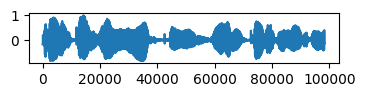

sStyle_wild:


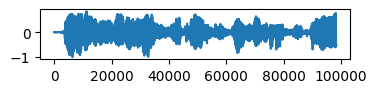

sPrediction_wild:


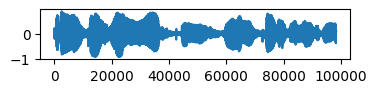

In [46]:
################## PLOT AND PLAY BACK CONTENT, STYLE, TARGET AND PREDICTION ##################

audios=[sContent, sStyle, sPrediction]
names=["sContent_wild", "sStyle_wild", "sPrediction_wild"]

plt.figure()
for i,audio in enumerate(audios):
    print(names[i]+":")
    plt.subplot(4,1,i+1)
    audio=audio.squeeze(0).cpu()
    if i==2:
        audio=audio.squeeze(0)
    plt.plot(audio)
    plt.show()
    display(Audio(audio,rate=48e3))


###  <font color='fuchsia'>Evaluation of the latent space</font>

In [43]:
################## GENERATE EMBEDDING ARRAY AND PARAMETER ARRAYS FROM MULTIPLE DATA POINTS ##################

emb_arr=np.zeros([len(dataset),512])
rt30_meas_arr=np.zeros([len(dataset),1])
edt_meas_arr=np.zeros([len(dataset),1])
c50_meas_arr=np.zeros([len(dataset),1])
rt60_set_arr=np.zeros([len(dataset),1])
rt60_true_arr=np.zeros([len(dataset),1])
for j,data in enumerate(dataset):
    # get style audio
    sStyle_in=data[1]
    # get style info
    df_Style=dataset.get_info(j,id="style")
    # get style embedding of size 512
    with torch.no_grad():
        embedding=model_ReverbEncoder(sStyle_in.unsqueeze(0).to(args.device))
        emb_arr[j,:]=embedding.cpu().numpy()
    rt30_meas_arr[j]=df_Style["rt30_meas"]
    rt60_set_arr[j]=df_Style["rt60_set"]
    rt60_true_arr[j]=df_Style["rt60_true"]
    edt_meas_arr[j]=df_Style["edt_meas"]
    c50_meas_arr[j]=df_Style["c50_meas"]
    if j==1000:
        break


In [322]:
################## PERFORM DIMENSIONALITY REDUCTION ON THE EMBEDDING SPACE ##################

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

indices_subset=range(1000)
# reduce dimensionality of the embeddings
# using pca:
embeddings_pca=PCA(n_components=2).fit_transform(emb_arr[indices_subset,:])
# using first pca and then tsne:
embeddings_pca_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(PCA(n_components=50).fit_transform(emb_arr[indices_subset,:]))
# using tsne:
embeddings_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(emb_arr[indices_subset,:])

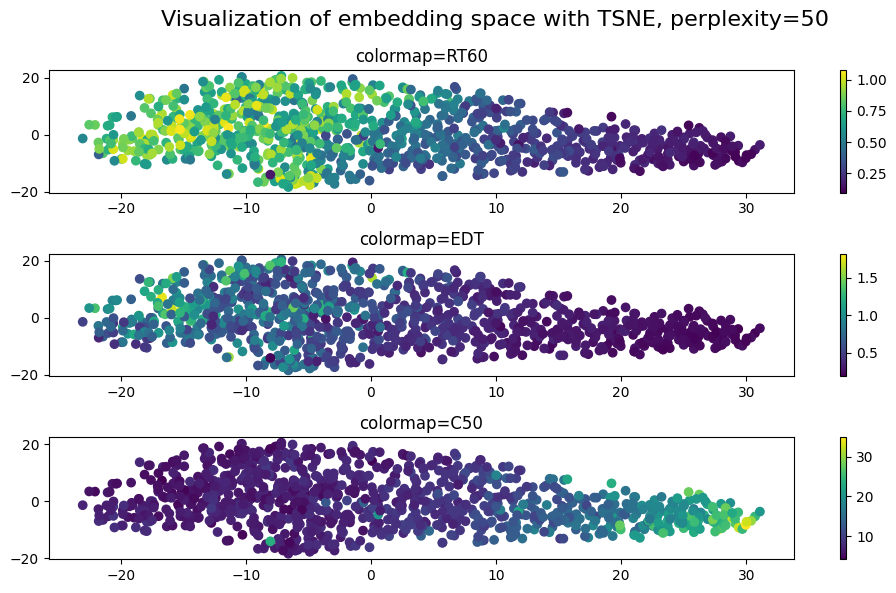

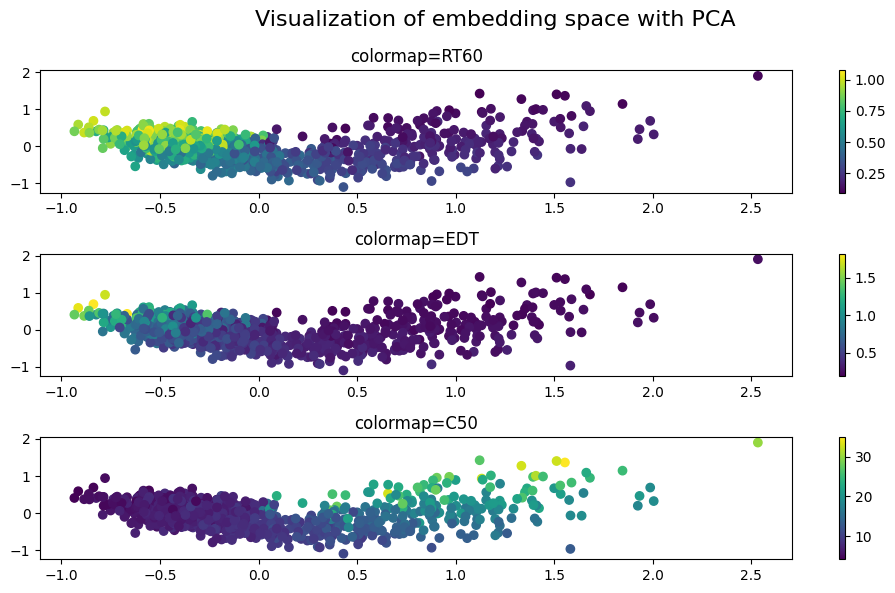

In [323]:
################## PLOT TSNE 2-DIM VISUALISATION OF THE EMBEDDING SPACE ##################

# plt.figure(figsize=(10,6))
# plt.suptitle('Visualization of embeddings with TSNE, perplexity=50', fontsize=16)
# plt.subplot(2,3,1)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt30_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt30 meas')
# plt.subplot(2,3,2)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt60 meas')
# plt.subplot(2,3,3)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_set_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt60 set')
# plt.subplot(2,3,4)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=edt')
# plt.subplot(2,3,5)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=c50')
# cmap = plt.get_cmap('cool')
# plt.set_cmap(cmap)


plt.figure(figsize=(10,6))
plt.suptitle('Visualization of embedding space with TSNE, perplexity=50', fontsize=16)
plt.subplot(3,1,1)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(3,1,2)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(3,1,3)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=C50')

plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.suptitle('Visualization of embedding space with PCA', fontsize=16)
plt.subplot(3,1,1)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(3,1,2)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(3,1,3)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=C50')

plt.tight_layout()
plt.show()

In [312]:
################## GENERATE EMBEDDING ARRAY AND PARAMETER ARRAYS FROM MULTIPLE DATA POINTS ##################


from torch.utils.data import Subset

# Create a special data set containing style data with only one specific impulse response
N_audios=100
N_irs=5
emb_arr=np.zeros([N_audios*N_irs,512])
id_array=np.zeros([N_audios*N_irs,1])


styleIR_indices=list(range(0, N_irs))
for i,idx in enumerate(styleIR_indices):
    args.split="test"
    args.style_rir=dataset.get_info(idx)["ir_file_path"]
    print(args.style_rir)
    dataset_this_ir=dset.DatasetReverbTransfer(args)
    indices_audios=list(range(0,N_audios))
    dataset_this_ir=Subset(dataset_this_ir,indices_audios)

    for j,data in enumerate(dataset_this_ir):
        # get style audio
        sStyle_in=data[1]
        # get style embedding of size 512
        with torch.no_grad():
            embedding=model_ReverbEncoder(sStyle_in.unsqueeze(0).to(args.device))
            emb_arr[(i*N_audios)+j,:]=embedding.cpu().numpy()
        id_array[(i*N_audios)+j]=i



/home/ubuntu/Data/synth_rirs_mono/monoRIR_x2284y2076z482_rtms102.wav
/home/ubuntu/Data/synth_rirs_mono/monoRIR_x2190y1384z476_rtms76.wav
/home/ubuntu/Data/synth_rirs_mono/monoRIR_x1142y722z393_rtms37.wav
/home/ubuntu/Data/synth_rirs_mono/monoRIR_x2981y2065z376_rtms99.wav
/home/ubuntu/Data/synth_rirs_mono/monoRIR_x587y383z302_rtms18.wav


In [319]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# reduce dimensionality of the embeddings
# using pca:
embeddings_pca=PCA(n_components=2).fit_transform(emb_arr)
# using first pca and then tsne:
embeddings_pca_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(PCA(n_components=50).fit_transform(emb_arr))
# using tsne:
embeddings_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(emb_arr)

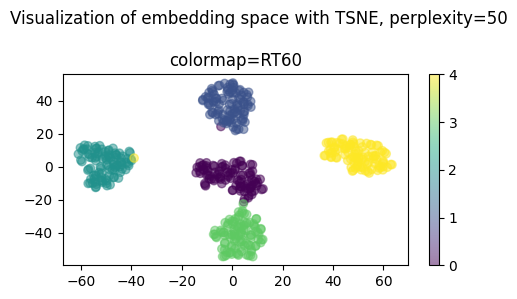

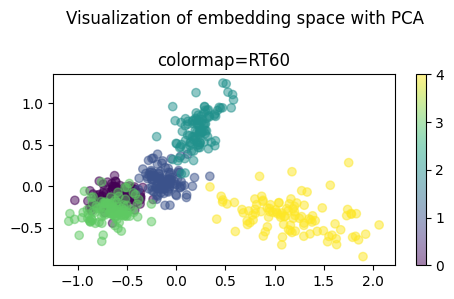

In [320]:

plt.figure(figsize=(5,3))
plt.suptitle('Visualization of embedding space with TSNE, perplexity=50', fontsize=12)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=id_array,alpha=0.5);plt.colorbar();plt.title('colormap=RT60')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.suptitle('Visualization of embedding space with PCA', fontsize=12)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=id_array, alpha=0.5);plt.colorbar();plt.title('colormap=RT60')
plt.tight_layout()
plt.show()




